In [1]:
import time
import numpy as np
import pandas as pd

In [2]:
path_to_data = "../../../../../data/variety_data_strict_r36_n100_rotation_invariant/train/"
path_to_testdata = "../../../../../data/variety_data_strict_r36_n100_rotation_invariant/test/"
path_to_result_dir = "./results/{}/".format(path_to_data.split("/")[-3])

## load data

In [3]:
# load csv
df = pd.read_csv("{}/tensor.csv".format(path_to_data), header=None, delimiter="\t")
df_label = pd.read_csv("{}/metadata.tsv".format(path_to_data), delimiter="\t", index_col=0)

testdf = pd.read_csv("{}/tensor.csv".format(path_to_testdata), header=None, delimiter="\t")
testdf_label = pd.read_csv("{}/metadata.tsv".format(path_to_testdata), delimiter="\t", index_col=0)

In [4]:
data = pd.concat([df_label, df], axis=1)
testdata = pd.concat([testdf_label, testdf], axis=1)

del df, df_label

## def loss

In [5]:
import scipy.spatial.distance
def cossim(x, y):
    return 1 - scipy.spatial.distance.cosine(x, y)

## Calculate

In [6]:
def t_is_continuous(t_prev, t_now, window_size):
    if t_now - t_prev == window_size:
        return True
    return False

In [7]:
def cossim_by_window(data, window_size):
    dates = set(data["Label_date"].values)
    N = data.shape[0]
    cossim_value = 0.
    count = 0
    init_t = time.time()
    for i, date in enumerate(dates):
        data_where_date = data[data["Label_date"]==date]
        idx_begin = data_where_date.index[0]
        idx_end = data_where_date.index[-1]
        indices = np.arange(idx_begin + window_size, idx_end)
        for j in indices:
            j_prev, j_now = j-window_size, j
            t_prev = data.iloc[j_prev, 1]
            t_now = data.iloc[j_now, 1]
            if t_is_continuous(t_prev, t_now, window_size):
                x_prev = data.iloc[j_prev, 3:]
                x_now = data.iloc[j_now, 3:]
                cossim_value += cossim(x_prev, x_now)
                count += 1
                print("\r{:0=6}/{}, {:0=3.1f}sec".format(count, N, time.time()-init_t), end="")
    return cossim_value/count

In [8]:
def calc_and_save(data, max_window, step_window):
    dict = {
        "window_size": [],
        "cossim_value": []
    }
    for window_size in range(1, max_window+1, step_window):
        ret = cossim_by_window(data, window_size)
        dict["window_size"].append(window_size)
        dict["cossim_value"].append(ret)
        print("\n window_size:{}, {:0=1.6f}".format(window_size, ret))
    return dict

In [10]:
import matplotlib.pyplot as plt
def plt_result(df, testdf, max_window, step_window):
    plt.scatter(x=df["window_size"], y=df["cossim_value"], label="train data")
    plt.scatter(x=testdf["window_size"], y=testdf["cossim_value"], label="test data")
    plt.xlabel("window size")
    plt.ylabel("cosin similarity")
    plt.legend()
    plt.savefig("{}cossim_train_vs_test_maxw{}_stepw{}.png".format(path_to_result_dir, max_window, step_window))

# 実行

250951/251416, 118.8sec
 window_size:1, 0.998410
209997/251416, 101.1sec
 window_size:201, 0.923861
182282/251416, 88.2sec
 window_size:401, 0.915006
160406/251416, 78.4sec
 window_size:601, 0.909021
141697/251416, 69.7sec
 window_size:801, 0.909197
195771/196028, 92.7sec
 window_size:1, 0.998193
173880/196028, 83.1sec
 window_size:201, 0.909236
157111/196028, 75.1sec
 window_size:401, 0.908885
143395/196028, 68.9sec
 window_size:601, 0.904837
131554/196028, 63.2sec
 window_size:801, 0.900498


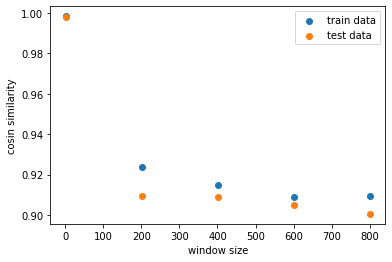

In [11]:

max_window = 1000
step_window = 200

dict = calc_and_save(data, max_window, step_window)
df = pd.DataFrame(dict)
df.to_csv("{}windowsize_cossim_maxw{}_stepw{}.csv".format(path_to_result_dir, max_window, step_window))

testdict = calc_and_save(testdata, max_window, step_window)
testdf = pd.DataFrame(testdict)
testdf.to_csv("{}windowsize_cossim_test_maxw{}_stepw{}.csv".format(path_to_result_dir, max_window, step_window))

plt_result(df, testdf, max_window, step_window)
